## Stratification of an area of interest - step 1

### Get ALL THE DATA

this notebook will collect spatial data and save them out as a series of geotiffs into a specified directory.

##### It's important to note that there is no pre-processing of the data here. The geotiffs will probably be in different projections, as Sentinel-2 data is stored in UTM. Any processing needed is handled in step 2/notebook 2.

In [14]:
%pip install dask -q
%pip install dask-expr -q
%pip install odc-stac -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


##### If you get an error saying a package doesn't exist, you sometimes need to restart the kernel after you've run the above cell that installs odc-stac and dask

In [15]:
import os
import json
from io import StringIO
import numpy as np
import geopandas as gpd
from geodata_fetch.harvest import DataHarvester
from gis_utils.dataframe import get_bbox_from_geodf
import dask.distributed
from pystac_client import Client
from odc.stac import configure_rio, load

This notebook is using odc-stac for fetching sentinel-2 data and generating spectral indices. The odc-stac package uses dask, so it has been installed as well. The step below that sets up the dask client is optional, but it does improve load speed for the sentinel-2 data collection.

In [16]:
client = dask.distributed.Client()
configure_rio(cloud_defaults=True, aws={"aws_unsigned": True}, client=client)

/usr/local/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34737 instead
  warnings.warn(
2024-07-04 01:02:30,891 - distributed.scheduler - INFO - State start
2024-07-04 01:02:30,899 - distributed.scheduler - INFO -   Scheduler at:     tcp://127.0.0.1:40163
2024-07-04 01:02:30,900 - distributed.scheduler - INFO -   dashboard at:  http://127.0.0.1:34737/status
2024-07-04 01:02:30,901 - distributed.scheduler - INFO - Registering Worker plugin shuffle


2024-07-04 01:02:30,920 - distributed.nanny - INFO -         Start Nanny at: 'tcp://127.0.0.1:45163'
2024-07-04 01:02:30,923 - distributed.nanny - INFO -         Start Nanny at: 'tcp://127.0.0.1:45019'
2024-07-04 01:02:30,928 - distributed.nanny - INFO -         Start Nanny at: 'tcp://127.0.0.1:41281'
2024-07-04 01:02:30,935 - distributed.nanny - INFO -         Start Nanny at: 'tcp://127.0.0.1:36717'
2024-07-04 01:02:30,943 - distributed.nanny - INFO -         Start Nanny at: 'tcp://127.0.0.1:45629'
2024-07-04 01:02:31,524 - distributed.scheduler - INFO - Register worker <WorkerState 'tcp://127.0.0.1:41905', name: 0, status: init, memory: 0, processing: 0>
2024-07-04 01:02:31,526 - distributed.scheduler - INFO - Starting worker compute stream, tcp://127.0.0.1:41905
2024-07-04 01:02:31,526 - distributed.core - INFO - Starting established connection to tcp://127.0.0.1:41842
2024-07-04 01:02:31,530 - distributed.scheduler - INFO - Register worker <WorkerState 'tcp://127.0.0.1:45207', name

 - `is_valid_pixel` uses the `scl` layer to identify and pixels that are either corrupt, empty, or classified as cloud, aerosols, dust etc. so we can exclude them from the NDVI calculations

In [17]:
def is_valid_pixel(data):
    """
    Check if a pixel value is valid based on the assigned value in the SCL layer

    Parameters:
    data (int): The pixel value to be checked.

    Returns:
    bool: True if the pixel value is valid, False otherwise.
    """

    # include only vegetated, not_vegitated, water, and snow
    return ((data > 3) & (data < 7)) | (data==11)

#### Setup import and export directories, bring in geometry for aoi

 - establish a directory to save the downloaded data to (output_dir)
 - set flags for the data to download - in this case, DEM, SLGA (you need to specify which SLGA layers) and sentinel-2. IF a flag is set to false, that data will not be downloaded

In [18]:
#links to input and output directories
#input_dir = "/workspace/notebooks/sandbox/data/stratification"
#test_areas_dir = os.path.join(input_dir, "test-areas")

output_dir = "/workspace/notebooks/sandbox/stratification/showcase/data/01-data_collection"

GET_DEM = True
GET_SLGA = False
GET_SENTINEL = True
GET_RADMAP = False

Pick the SLGA layers you want to download and put them in the `slga_sources` variable. You need to include both the attribute name (e.g. `Organic_Carbon` as well as the depth layer (`0-5cm`), as you can get data from surface to 2m depth).

Do not edit the DEM inputs. If you do not want DEM, use the flag setting above.

In [19]:
dem_source = {
    "DEM": "DEM"
}


slga_sources = {
    "SLGA": {
        "Organic_Carbon": ["0-5cm"],
        "Bulk_Density": ["0-5cm"]
    }
}


Set the endpoint for the STAC catalog (using Element84's because they are awesome)

Set the start and end date for the Sentinel-2 data to collect.
- It's important to get several months of data, as the final output file will be a median composite of the spectral index. We want to make sure the index represents the average state of the area of interest, not a single snapshot in time that may be influenced by short-term trends like heavy rainfall.

set the resolution - this is optional. If you leave this as 10, the data will be in the default spatial resolution of Sentinel-2, but because the other data layers will be resampled to this resolution in the next notebook, it's a good diea to choose something coarser. Resampling 90m to 10m is a bit of a stretch.

In [20]:
# setup stac for getting veg indices later

stac_url_sentinel = "https://earth-search.aws.element84.com/v1/"
collection_sentinel = "sentinel-2-l2a"

start_date = "2024-03-01"
end_date = "2024-06-01"

resolution = 20

In [21]:
geojson = {
    'body': {
        "type": "FeatureCollection",
        "name": "dissolved-boundaries",
        "crs": {
            "type": "name",
            "properties": {
                "name": "urn:ogc:def:crs:OGC:1.3:CRS84" 
            }
        },
        "features": [
            {
                "type": "Feature",
                "properties": {
                    "fid": 1
                },
                "geometry": {
                    "type": "Polygon",
                    "coordinates": [
                        [
                            [116.26012130269045, -29.225295369642396],
                            [116.261724812149055, -29.241374854584375],
                            [116.283751968396274, -29.256813692452539],
                            [116.284342735038919, -29.268250184258388],
                            [116.292247755352392, -29.265992437426529],
                            [116.292360282331941, -29.293057573630019],
                            [116.314865678242256, -29.293523728033122],
                            [116.326259034921833, -29.293033039128805],
                            [116.326315298411629, -29.305397680579894],
                            [116.355065941687045, -29.307016748931797],
                            [116.355065941687045, -29.306575187382712],
                            [116.383366477044206, -29.307384715430175],
                            [116.384322956370426, -29.290407813444993],
                            [116.387586238777402, -29.282629879611861],
                            [116.386517232471661, -29.259807919053017],
                            [116.359201308185533, -29.259488866292969],
                            [116.359229439930417, -29.259243440415627],
                            [116.35242155766754, -29.259292525638209],
                            [116.352140240218716, -29.220237788279107],
                            [116.302234524787593, -29.223503148505326],
                            [116.281388901825679, -29.2239696200396],
                            [116.26012130269045, -29.225295369642396]
                        ]
                    ]
                }
            }
        ]
    }
}

Convert the input json to a geopandas geometry and get the bounding box

/tmp/ipykernel_621/3462533652.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_lon = gdf.centroid.x[0] #approximate centre latitude based on the input geojson - point roughly in the middle
/tmp/ipykernel_621/3462533652.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_lat = gdf.centroid.y[0]


bbox: [116.26012130269045, -29.307384715430175, 116.3875862387774, -29.220237788279107]


<Axes: >

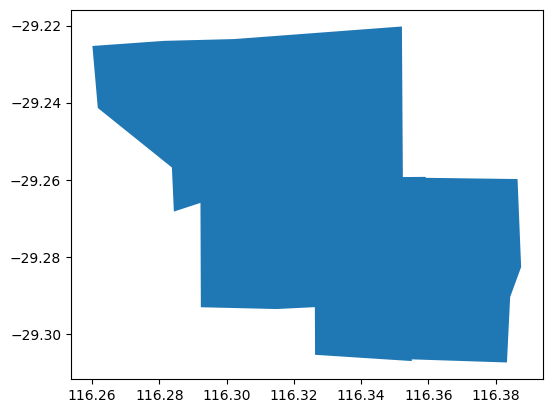

In [22]:
# import geometry for area of interest

req = geojson
geojson_data = req['body']  # Directly accessing the 'body' since it's already a dictionary in this mock setup

# Convert the GeoJSON string to a GeoDataFrame
gdf = gpd.read_file(StringIO(json.dumps(geojson_data)))

geom = gdf.geometry #for data-harvester clip function

bbox = get_bbox_from_geodf(geojson_data)
gdf_lon = gdf.centroid.x[0] #approximate centre latitude based on the input geojson - point roughly in the middle
gdf_lat = gdf.centroid.y[0]

print(f"bbox: {bbox}")

gdf.plot()

#### Set up the json object to be sent to the data harvester

In [23]:
propertyName = "stardew_valley"


data_mask=True #we want the full geotiffs so making the datacube is easier
add_buffer = False
resample=False #we will handle resampling in the pre-processing notebook to maintain consistency.

# Resolution of data download in arcseconds (1 arcsec ~ 30m)
target_res = 1
target_proj = "EPSG:4326" # We will reproject to 3857 later on. This will be more accurate for data collection and pre-processing steps.

date_start = "2022-10-01" #these aren't needed for SLGA but are expected in the package and throw error if excluded - need to fix
date_end = "2022-11-30"
time_intervals = 0 #same issue as above, need to fix in geodata package to be optional.

The data harvester is run separately for the DEM and for SLGA, each within a conditional loop that will run if the associated flag is set to `True`.

In [24]:
if GET_DEM is True:
    json_data = {
        "property_name":propertyName,
        "outpath": output_dir,
        "data_mask": data_mask,
        "target_res": str(target_res),
        "target_crs": target_proj,
        "date_start": date_start if date_start is not None else "2022-10-01", #a date of some kind must be provided or the harvester complains
        "date_end": date_end if date_end is not None else "2022-11-30",
        "target_centroid_lat": gdf_lat,
        "target_centroid_lng": gdf_lon,
        "time_intervals": time_intervals,
        "target_sources": dem_source,
        "target_bbox": bbox,
        "add_buffer": add_buffer,
        "resample": resample
    }

    #do this to check for any inputs that can't be serialised to json
    for key, value in json_data.items():
        if isinstance(value, np.ndarray):
            print(f"Key '{key}' contains an ndarray.")
    data = json.dumps(json_data)

    # Create a file-like object from JSON string
    json_file_like = StringIO(data)
    
    harvester = DataHarvester(json_file_like, geom)
    harvester.run()

    for file in os.listdir(output_dir):
        file_end = propertyName + ".tiff"
        if file.startswith("DEM") and file.endswith(file_end):
            print(file)
            os.remove(os.path.join(output_dir,file))

    
else:
    pass


Requested the following 1 sources: ['DEM']
/workspace/notebooks/sandbox/stratification/showcase/data/01-data_collection/DEM_SRTM_1_Second_Hydro_Enforced_stardew_valley.tiff


2024-07-04 01:02:32,840 - root - ERROR - Error occurred while reprojecting and masking raster NDVI_median_2024-03-01_2024-06-01_stardew_valley.tiff: No data found in bounds.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/site-packages/geodata_fetch/utils.py", line 349, in reproj_mask
    clipped = input_raster.rio.clip(
  File "/usr/local/lib/python3.10/site-packages/rioxarray/raster_array.py", line 923, in clip
    raise NoDataInBounds(
rioxarray.exceptions.NoDataInBounds: No data found in bounds.


Masking data in /workspace/notebooks/sandbox/stratification/showcase/data/01-data_collection
files to mask: ['NDVI_median_2024-03-01_2024-06-01_stardew_valley.tiff', 'DEM_SRTM_1_Second_Hydro_Enforced_stardew_valley.tiff']
DEM_SRTM_1_Second_Hydro_Enforced_stardew_valley.tiff


In [25]:
if GET_SLGA is True:
    json_data = {
        "property_name":propertyName,
        "outpath": output_dir,
        "data_mask": data_mask,
        "target_res": str(target_res),
        "target_crs": target_proj,
        "date_start": date_start if date_start is not None else "2022-10-01", #a date of some kind must be provided or the harvester complains
        "date_end": date_end if date_end is not None else "2022-11-30",
        "target_centroid_lat": gdf_lat,
        "target_centroid_lng": gdf_lon,
        "time_intervals": time_intervals,
        "target_sources": slga_sources,
        "target_bbox": bbox,
        "add_buffer": add_buffer,
        "resample": resample
    }

    #do this to check for any inputs that can't be serialised to json
    for key, value in json_data.items():
        if isinstance(value, np.ndarray):
            print(f"Key '{key}' contains an ndarray.")
    data = json.dumps(json_data)

    # Create a file-like object from JSON string
    json_file_like = StringIO(data)
    
    harvester = DataHarvester(json_file_like, geom)
    harvester.run()

    for file in os.listdir(output_dir):
        file_end = propertyName + ".tiff"
        if file.startswith("DEM") and file.endswith(file_end):
            print(file)
            os.remove(os.path.join(output_dir,file))
else:
    pass

#### Get Sentinel-2 and indices

Collecting Sentinel-2 (or in future, Landsat) is not currently aprt of the geodata pythong package. So instead we use `pystac_client` and `odc-stac` to search for Sentinel-2 data that covers the area of interest, within the timeframe of interest, and then download only the spectral bands needed to calcualte the indices we're interested in.

This notebook uses `odc-stac` instead of `stackstac` as `odc-stac` has better support. It is built and maintained by Goescience Australia, whereas `stackstac` was developed and maintained by a single freelance developer. `odc-stac` is used more within the RSGIS community so we should consider this for our applications for now.

##### Steps this cell performs:
- establish connection to Element84 catalog and select the `[sentinel-2-l2a]` collection. It is important to use the L2A collection as this has been processed to remove atmospheric conditions that affect index calculations over time.
- Use `odc-stac` to "lazily load" the sentinel-2 scenes that cover the bounding box. This only loads the pixels within the bounding box instead of the entire scene (much smaller area) and only downloads the spectral bands we select. The data is loaded to memory as an xarray data array
- creates a val;id pixel mask using the `is_valid_pixel` function
- for each time dimension in the data array, calculate the NDVI. This means for each 'day' we have Sentinel-2 data in the array, we now have an NDVI
- calculate the median NDVI based on the calcualted individual NDVI's.
- save out the median NDVI in the same directory as the DEM and SLGA geotiffs

In [26]:
if GET_SENTINEL is True:
    catalog = Client.open(stac_url_sentinel)

    query = catalog.search(
        collections=["sentinel-2-l2a"],
        datetime=f"{start_date}/{end_date}",
        bbox=bbox
    )

    #print(query.item_collection_as_dict())

    for item in query.items_as_dicts():
        print(item['id'])

    #lazily combine
    xx = load(
        query.items(),
        bands = ("red", "nir", "scl"),
        resolution = resolution,
        chunks={}, # use dask
        groupby = "solar_day", #this merges adjacent scenes and de-duplicates overlapping pixels
        bbox = bbox,
        resampling="bilinear"
    )

    xx['valid'] = is_valid_pixel(xx.scl)
    xx = xx/10000

    xx['ndvi'] = (xx.nir - xx.red) / (xx.nir + xx.red)

    ndvi_median = (
        xx['ndvi']
        .where(xx.valid)
        .median(dim="time")
    )

    ndvi_median_masked = ndvi_median.rio.clip(gdf.geometry.values, gdf.crs, drop=False, invert=False)
    #ndvi_median_masked.plot.imshow()
    ndvi_filename = f"NDVI_median_{start_date}_{end_date}_{propertyName}.tiff"
    ndvi_filepath = os.path.join(output_dir, ndvi_filename)
    ndvi_tiff = ndvi_median_masked.odc.write_cog(ndvi_filepath, overwrite=True)


S2A_50JMN_20240530_0_L2A
S2B_50JMN_20240525_0_L2A
S2A_50JMN_20240520_0_L2A
S2B_50JMN_20240515_0_L2A
S2A_50JMN_20240510_0_L2A
S2B_50JMN_20240505_0_L2A
S2A_50JMN_20240430_0_L2A
S2B_50JMN_20240425_0_L2A
S2A_50JMN_20240420_0_L2A
S2B_50JMN_20240415_0_L2A
S2B_50JMN_20240405_0_L2A
S2A_50JMN_20240331_0_L2A
S2B_50JMN_20240326_0_L2A
S2A_50JMN_20240321_0_L2A
S2B_50JMN_20240316_0_L2A
S2B_50JMN_20240306_0_L2A
S2A_50JMN_20240301_0_L2A
